In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt
from datetime import date

In [2]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

In [3]:
## 평가모듈
import evaluation_module as evm

## Data

In [4]:
date_idx = date.today().strftime('%Y-%m-%d')

score_ori = pd.read_csv(f'data/result_{date_idx}.csv', index_col=0)
score_ori.index = pd.to_datetime(score_ori.index)

## assets = ['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU']
assets = ['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY']
assets_hat = [i + '_hat' for i in assets]

score_df = score_ori[assets_hat]
score_df.columns = assets

In [5]:
asset_ori = pd.read_csv('data/assets.csv', index_col=0)
asset_ori.index = pd.to_datetime(asset_ori.index)
asset_df = asset_ori.resample('M').last()
rets = asset_df.pct_change().dropna()
rets = rets[assets]

## Score -> Weight

### Score 차등 배분 방식

In [6]:
## 음수자산 0
df = score_df.dropna().copy()
for col in df.columns:
    df[col][df[col]<=0] = 0

## 모든자산 0 => 단기채 1
df['SHY'][df.sum(axis=1) <= 0] = 1

## 예측값 기준 차등배분
df_w = (df.T/df.sum(axis=1)).T

In [7]:
## 이번달 자산배분
df_w.tail(5)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY
0,,,,,,,
2021-11-30,0.094462,0.197615,0.0,0.271110,0.253526,0.064858,0.118429
2021-12-31,0.033822,0.000000,0.0,0.491309,0.135475,0.048341,0.291054
2022-01-31,0.000000,0.000000,0.0,0.609710,0.000000,0.000000,0.390290
2022-02-28,0.000000,0.000000,0.0,0.568328,0.000000,0.000000,0.431672
2022-03-31,0.000000,0.000000,0.0,0.542400,0.000000,0.000000,0.457600


### Score 최유리 집중 방식

In [37]:
df = score_df.dropna().copy().T
## 상위1종목
top5_fun = lambda srs : srs.sort_values(ascending = False).head(1).index
for col in df.columns:
    trgt = top5_fun(df[col])
    df[col] = 0 ## 투자제외 종목
    df[col][trgt] = 1 ## 투자대상 종목 표기
df_w2 = df.T

In [38]:
## 이번달 자산배분
df_w2.tail(5)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY
0,,,,,,,
2021-10-31,0,0,0,0,1,0,0
2021-11-30,0,0,0,0,1,0,0
2021-12-31,0,0,0,0,0,0,1
2022-01-31,0,0,0,0,0,0,1
2022-02-28,0,0,0,0,0,0,1


## 성능평가

### 요약

In [39]:
## ML: 스코어 차등배분 방식
rets_w1 = (rets * df_w).dropna().sum(axis=1)
## ML: 스코어 집중 방식
rets_w2 = (rets * df_w2).dropna().sum(axis=1)
## BM: 동일가중 포트폴리오
rets_bm = rets.mean(axis=1)[rets_w1.index]
## BM2: QQQ B&H
rets_bm2 = rets['QQQ'][rets_w1.index]

In [40]:
df_rets = pd.DataFrame([rets_w1, rets_w2, rets_bm, rets_bm2],
                       index=['GRU1', 'GRU2', 'BM', 'BM2']).T.dropna()
report = evm.get_report2(df_rets)
print('전기간 성능평가')
report

전기간 성능평가


,Return,Volatility,Sharpe,MDD,Win
GRU1,0.2324,0.1096,2.1211,-0.0380,0.7516
GRU2,0.2631,0.1490,1.7657,-0.0897,0.6561
BM,0.0966,0.0829,1.1656,-0.0778,0.6497
BM2,0.2137,0.1662,1.2859,-0.1309,0.6497


In [41]:
df_rets = pd.DataFrame([rets_w1, rets_w2, rets_bm, rets_bm2],
                       index=['GRU1', 'GRU2', 'BM', 'BM2']).T.dropna()
report = evm.get_report2(df_rets.tail(12*5))
print('최근5년(Test&Valid기간) 성능평가')
report

최근5년(Test&Valid기간) 성능평가


,Return,Volatility,Sharpe,MDD,Win
GRU1,0.1783,0.0944,1.8892,-0.0380,0.7167
GRU2,0.1912,0.1272,1.5029,-0.0897,0.6167
BM,0.0911,0.0828,1.0999,-0.0778,0.6833
BM2,0.2204,0.1800,1.2243,-0.1309,0.6833


### 추이

In [23]:
## GRU1, GRU2만 남김
df_rets_clean = df_rets[['GRU1', 'GRU2', 'BM', 'BM2']]

<AxesSubplot:>

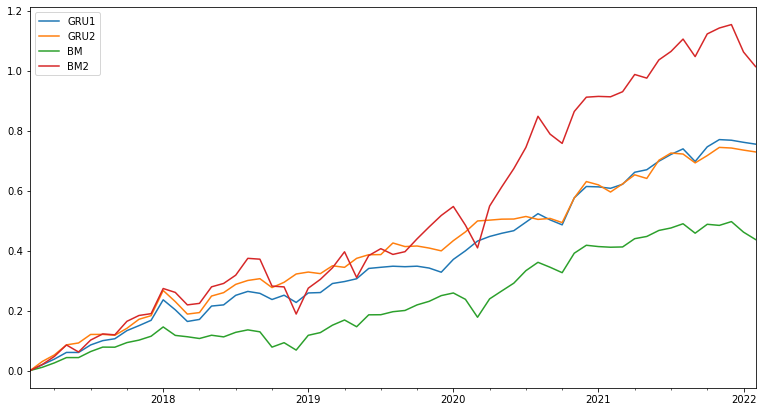

In [24]:
df_value = evm.get_df_val(df_rets_clean.tail(12*5))
np.log(df_value).plot()

### MDD

In [25]:
df_dd = evm.get_dd(df_value)

<AxesSubplot:>

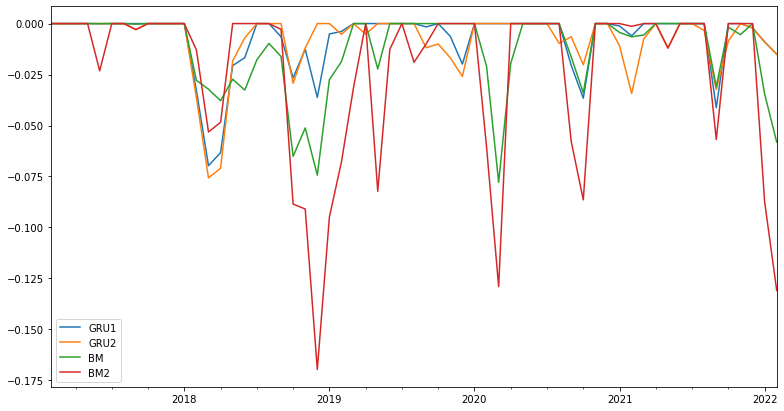

In [26]:
df_dd.plot()

### 배분율

In [266]:
df_w.mean()

SPY    0.099741
QQQ    0.243708
VEA    0.147098
VWO    0.131085
TLT    0.230175
IEF    0.121245
SHY    0.026947
dtype: float64

In [267]:
df_w2.mean()

SPY    0.000000
QQQ    0.363057
VEA    0.121019
VWO    0.133758
TLT    0.343949
IEF    0.012739
SHY    0.025478
dtype: float64

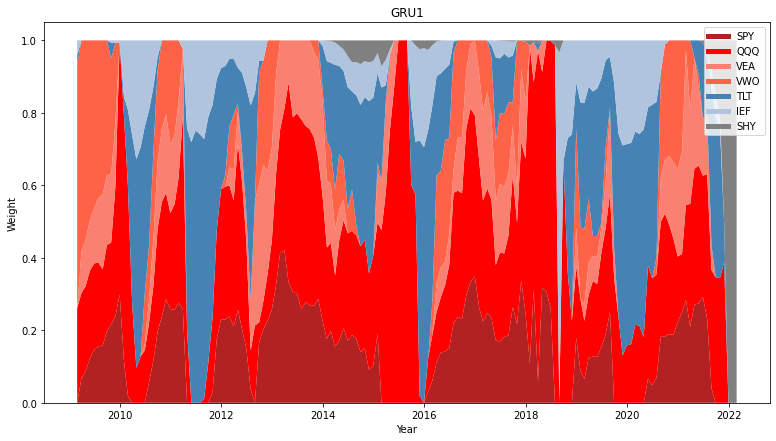

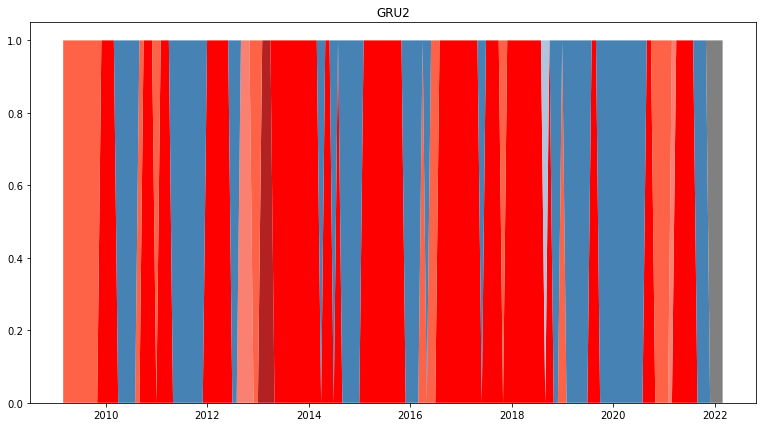

In [249]:
colors = ['#B22222', 'red', '#FA8072', '#FF6347', '#4682B4', '#B0C4DE', 'gray', '#FF8C00']

plt.plot([], [], color='#B22222', label='SPY', linewidth=5)
plt.plot([], [], color='red', label='QQQ', linewidth=5)
plt.plot([], [], color='#FA8072', label='VEA', linewidth=5)
plt.plot([], [], color='#FF6347', label='VWO', linewidth=5)
plt.plot([], [], color='#4682B4', label='TLT', linewidth=5)
plt.plot([], [], color='#B0C4DE', label='IEF', linewidth=5)
plt.plot([], [], color='gray', label='SHY', linewidth=5)
## plt.plot([], [], color='#FF8C00', label='IAU', linewidth=5)
plt.xlabel('Year')
plt.ylabel('Weight')


## GRU1
plt.stackplot(df_w.index, df_w['SPY'], df_w['QQQ'], df_w['VEA'],
              df_w['VWO'], df_w['TLT'], df_w['IEF'], df_w['SHY'], colors = colors)
plt.legend()
plt.title('GRU1')
plt.show()

## GRU2
plt.stackplot(df_w2.index, df_w2['SPY'], df_w2['QQQ'], df_w2['VEA'],
              df_w2['VWO'], df_w2['TLT'], df_w2['IEF'], df_w2['SHY'], colors = colors)
plt.title('GRU2')
plt.show()